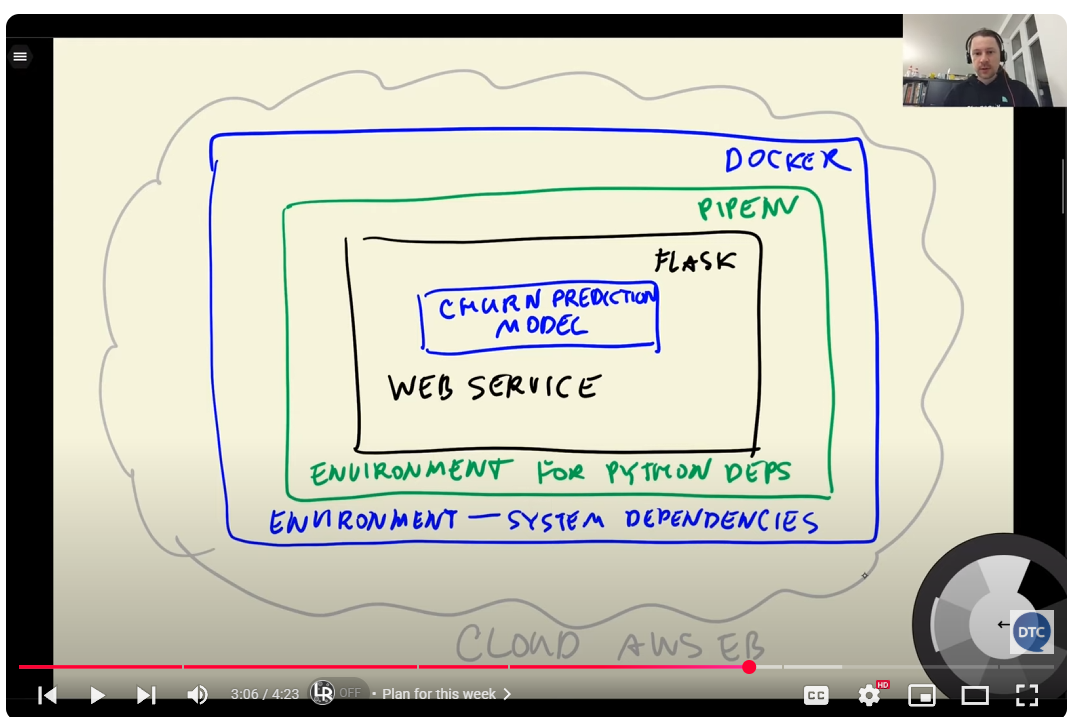

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [3]:

df = pd.read_csv('data-week-3.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [4]:

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [5]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [6]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [7]:

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

np.float64(0.8034066713981547)

#  change code to fucntion do train and predict 

In [8]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=5000)
    model.fit(X_train, y_train)

    return dv, model

In [9]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [10]:
C = 1.0
n_splits = 5

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.churn.values
    y_val = df_val.churn.values

    dv, model = train(df_train, y_train, C=C)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))


C=1.0 0.842 +- 0.007


In [11]:
scores

[0.8443649865375105,
 0.8450101807707588,
 0.8335661248244031,
 0.8347808882778027,
 0.8517225691067114]

In [12]:
dv, model = train(df_full_train, df_full_train.churn.values, C=10)
y_pred = predict(df_test, dv, model)
auc = roc_auc_score(y_test, y_pred)
auc

0.8584221673329218

# save model 

In [13]:
import pickle 

In [14]:
out_file=f'model_C={C}.bin'
out_file

'model_C=1.0.bin'

In [15]:
f_out=open(out_file, 'wb')
pickle.dump((dv,model),f_out)
f_out.close()

In [16]:
with open(out_file, 'wb') as f_out:
    pickle.dump((dv,model),f_out)



In [17]:
out_file='model_C=1.0.bin'

# load model

In [18]:
with open(out_file, 'rb') as f_in:
    pickle.load(f_in)

In [19]:
dv, model

(DictVectorizer(sparse=False), LogisticRegression(C=10, max_iter=5000))

In [20]:
customer = {
    'gender': 'female',
    'seniorcitizen': 0,
    'partner': 'yes',
    'dependents': 'no',
    'phoneservice': 'no',
    'multiplelines': 'no_phone_service',
    'internetservice': 'dsl',
    'onlinesecurity': 'no',
    'onlinebackup': 'yes',
    'deviceprotection': 'no',
    'techsupport': 'no',
    'streamingtv': 'no',
    'streamingmovies': 'no',
    'contract': 'month-to-month',
    'paperlessbilling': 'yes',
    'paymentmethod': 'electronic_check',
    'tenure': 1,
    'monthlycharges': 29.85,
    'totalcharges': 29.85
}

In [22]:
x=dv.transform([customer])

In [25]:
model.predict_proba(x)

array([[0.37161995, 0.62838005]])